# Interpreting the Projection and Feed-Forward Layers in a Self-Attention Block

> A summary of my experiments to understand the projection layer and feed-forward layer of a self-attention block.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide

from pathlib import Path
from typing import Dict, Optional, Iterable, Sequence, Tuple

In [ ]:
# | hide

from fastcore.test import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import KMeans
import torch 
from tqdm.auto import tqdm

In [ ]:
# Set a manual seed so output is deterministic (used same value as @karpathy)
_ = torch.manual_seed(1337)

In [ ]:
# | hide

from transformer_experiments.common.text_analysis import SubstringFrequencyAnalysis
from transformer_experiments.common.utils import aggregate_by_string_key, DataWrapper
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer import (
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsExperiment,
    BlockInternalsResult,
    BlockInternalsAnalysis,
)
from transformer_experiments.experiments.logit_lens import LogitLens 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cpu


In [ ]:
# Define an experiment for each block
block_internals_exps = [
    BlockInternalsExperiment(
        eh=encoding_helpers,
        accessors=accessors,
        block_idx=block_idx,
        results_folder=Path('../artifacts//block_internals_results'),
    )
    for block_idx in range(n_layer)
]

In [ ]:
# Aggregate the results for each block
block_internals_results = [
    aggregate_by_string_key(
        items=exp.raw_results(), key=lambda result: result.substring
    )
    for exp in block_internals_exps
]

In [ ]:
#| hide
# Sanity check
# Get the heads output and proj output manually
s = 'BAP'
block_idx = 0

tokens = encoding_helpers.tokenize_string(s)
x = accessors.embed_tokens(tokens)
for i in range(block_idx):
    x = m.blocks[i](x)

# Create a copy of the block we're interested in
block, io_accessor = accessors.copy_block_from_model(block_idx=block_idx)
_ = block(x)  # Run the block

# Get the results from the experiment
result_bap = block_internals_results[block_idx]['BAP']

test_close(result_bap.heads_output, io_accessor.input('sa.proj')[0][-1])
test_close(result_bap.proj_output, io_accessor.output('sa.proj')[0][-1])
test_close(result_bap.ffwd_output, io_accessor.output('ffwd')[0][-1])

## Clustering the Projection Layer Outputs

  0%|          | 0/50 [00:00<?, ?it/s]

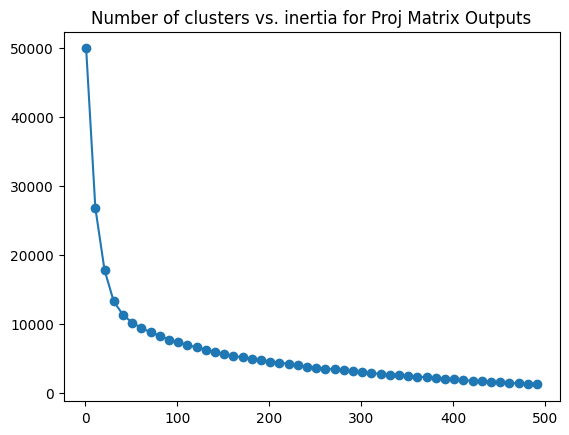

In [ ]:
#| eval: false
# Try kmeans clustering the proj outputs with a range of k values to determine where the inertia levels off
block_idx = 0
s_len = 3

substrs, proj_outputs = zip(*[
    (result.substring, result.proj_output)
    for result in block_internals_results[block_idx].values()
    if len(result.substring) == s_len
])

inertias = []
ks = range(1, 500, 10)
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(proj_outputs)
    inertias.append(kmeans.inertia_)

# Plot the intertias
plt.plot(ks, inertias, '-o')
_ = plt.title("Number of clusters vs. inertia for Proj Matrix Outputs")


Eyeballing this, it looks like the elbow is around 50 clusters. We'll go with that. 

In [ ]:
#| code-fold: true
#| code-summary: Helper code for clustering
class Cluster:
    """A cluster of substrings."""

    def __init__(self, center: torch.Tensor):
        self.center = center
        self.substrs: Sequence[str] = []

    def append(self, substr: str):
        self.substrs.append(substr)

    def __iter__(self):
        return iter(self.substrs)

    def __len__(self):
        return len(self.substrs)
    
    def __str__(self):
        return f'Cluster(center={self.center}, substrs={self.substrs})'


StrToClusterMap = Dict[str, Cluster]  # Map from substring to cluster


def cluster_data_for_substrings(
    substrs: Sequence[str], data: torch.Tensor, n_clusters: int
) -> Tuple[Sequence[Cluster], StrToClusterMap]:
    """Given a set of substrings and a data tensor in which the element
    at index i corresponds to the substring at index i, clusters the data
    into `n_clusters` clusters. Returns the clusters and a map from
    substrings to clusters."""
    assert len(substrs) == len(data)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(data)

    clusters = [Cluster(torch.tensor(c)) for c in kmeans.cluster_centers_]
    substr_to_cluster = {}
    for i, label in enumerate(kmeans.labels_):
        cluster = clusters[label]
        cluster.append(substrs[i])
        substr_to_cluster[substrs[i]] = cluster

    # Sort the clusters by length
    clusters = sorted(clusters, key=lambda cluster: len(cluster), reverse=True)

    return clusters, substr_to_cluster


In [ ]:
# Run clustering on the proj outputs for all blocks
s_len = 3
n_clusters_proj_out = 50 # Based on the elbow analysis above

all_kmeans_results_proj_out = []
for block_idx in tqdm(range(n_layer)):
    substrs, proj_outputs = zip(*[
        (result.substring, result.proj_output)
        for result in block_internals_results[block_idx].values()
        if len(result.substring) == s_len
    ])
    clusters, substr_to_cluster = cluster_data_for_substrings(
        substrs=substrs, data=torch.stack(proj_outputs), n_clusters=n_clusters_proj_out
    )
    all_kmeans_results_proj_out.append((clusters, substr_to_cluster))


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#| code-fold: true
#| code-summary: Helper function for getting the all the other strings in a cluster given a string
def clusters_for_substring(s: str, str_to_cluster_maps: Sequence[StrToClusterMap]):
    return DataWrapper(
        data=[
            str_to_cluster_maps[block_idx][s]
            for block_idx in range(n_layer)
        ],
        format_item_fn=lambda item: ", ".join([repr(substr) for substr in item]),
    )

In [ ]:
# Print proj output clustering
clusters_for_substring('BAP', [str_to_cluster for _, str_to_cluster in all_kmeans_results_proj_out]).print()

'hat', ' a ', '\nAs', ' as', 'ian', 'BAP', 'har', 'fat', 'Was', 'tak', 'ear', 'pav', 'dam', 'mad', 'NA:', 'cal', 'NAT', 'Kat', 'ray', ' af', "ta'", 'eat', 'lav', 'way', 'pal', 'mak', 'rav', 'eak', 'hal', 'ran', 'par', ' an', '\nAn', 'mas', 'say', 'dau', ' ar', 'nap', 'tam', 'cab', 'hav', '-al', 'ead', 'rat', 'may', 'han', 'lab', 'eas', 'lan'
'be ', 'ble', 'BAP', 've ', 'ven', 'Bia', 'but', 'bit', 'bli', 'bes', 'bed', 'bet', 'Bio', 'bro', 'blo', 'ver'
'BAP', 'Bia', 'BIA', 'Bio', 'BIO'
'be ', 'ble', 'BAP', 'Bia', 'but', 'bit', 'bli', 'bes', 'bed', 'bet', 'Bio', 'bro', 'blo'
'ARI', 'ATH', 'BAP', 'Ay,', 'ANI', 'And', 'A:\n', 'Abs', 'A g', 'ALO', 'ANT'
'BAP', 'Bia', 'BIA', 'Bio', 'Din', 'TIA'


## Clustering the FFWD Layer Outputs

  0%|          | 0/50 [00:00<?, ?it/s]

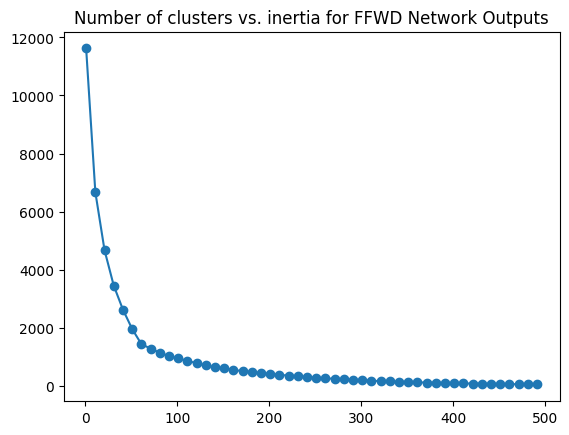

In [ ]:
#| eval: false
# Try kmeans clustering the ffwd outputs with a range of k values to determine where the inertia levels off
block_idx = 0
s_len = 3

substrs, ffwd_outputs = zip(*[
    (result.substring, result.ffwd_output)
    for result in block_internals_results[block_idx].values()
    if len(result.substring) == s_len
])

inertias = []
ks = range(1, 500, 10)
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(ffwd_outputs)
    inertias.append(kmeans.inertia_)

# Plot the intertias
plt.plot(ks, inertias, '-o')
_ = plt.title("Number of clusters vs. inertia for FFWD Network Outputs")


This one looks like the elbow is a little higher. Let's pick 60.

In [ ]:
# Run clustering on the proj outputs for all blocks
s_len = 3
n_clusters_ffwd_out = 60 # Based on the elbow analysis above

all_kmeans_results_ffwd_out = []
for block_idx in tqdm(range(n_layer)):
    substrs, ffwd_outputs = zip(*[
        (result.substring, result.ffwd_output)
        for result in block_internals_results[block_idx].values()
        if len(result.substring) == s_len
    ])
    clusters, substr_to_cluster = cluster_data_for_substrings(
        substrs=substrs, data=torch.stack(ffwd_outputs), n_clusters=n_clusters_ffwd_out
    )
    all_kmeans_results_ffwd_out.append((clusters, substr_to_cluster))

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Print ffwd output clustering
clusters_for_substring('BAP', [str_to_cluster for _, str_to_cluster in all_kmeans_results_ffwd_out]).print()

'BAP', '\n\nP'
'ATH', 'RIN', 'TRU', 'UCH', 'BAP', 'IST', 'REM', 'NAT', 'IEL', 'PET', 'ENT', 'CEN', 'TON', 'ERO', 'ROS', 'ALO', 'SEB', 'ANT', 'LON'
'STA', 'ATH', 'RIN', 'TRU', 'UCH', 'BAP', 'REM', 'd G', 'TRA', 'LUC', 'RUC', 'ETR', 'CEN', 'INA', '\nPE', 'ERO', 'SPE', '\nPR', 'ROS', 'ALO', 'NZA'
'ond', '\nYo', ' wo', "\nI'", 'iss', 'BAP', ' mi', 'irt', '\nOf', 'tir', ', J', ' yo', 'ANI', "ta'", 'all', '\nOr', 'ing', '\n\nP', ' sk', 'RUC', 'son', 'tio', 'ors', 'dau', 'TON', 'inc', 'ati', 'rit', 'ous', 'thi', 'ROS', 'end', 'ALO', 'ONI', 'ort'
'ATH', 'cuf', 'sho', 'TRU', 'UCH', 'hus', 'BAP', 'tak', 'wet', 'aus', 'omi', 'Som', 'REM', 'com', 'cal', 'NAT', 'Kat', ' af', 'ANI', "ta'", 'ang', 'mak', 'PET', ' ow', 'ath', 'Bio', 'dou', 'som', 'dau', ' ar', 'tam', 'tim', 'ois', 'ous', 'rom', 'ali', 'SEB', 'ONI', 'ANT'
'BAP', 'PET', 'RUC', 'CEN', 'ROS', 'LON'


## A More Detailed Look into the number of clusters

Earlier, we just did elbow analysis of one block to choose a number of clusters. But the right number of clusters might be very different for different blocks. We can do elbow analysis for each block, but here let's look at two other potentially interesting measures:

For a given prompt, as k (# of clusters) changes:
1. How does the size of the cluster containing the prompt change?
2. How many tokens have non-zero frequencies in the cumulative frequency distribution of the cluster containing the prompt?

In [ ]:
class ClusterSizeAnalysis:
    def __init__(
        self, 
        accessors: TransformerAccessors,
        encoding_helpers: EncodingHelpers,
        prompt: str,
        ks: Iterable[int], # The cluster sizes to try
        substrs: Sequence[str], # The substrings corresponding to the data points
        data: torch.Tensor, # The data points to cluster
        text: str # The text from which the substrings were extracted (used for frequency analysis)
    ):
        self.accessors = accessors
        self.encoding_helpers = encoding_helpers
        self.prompt = prompt
        
        self.ks = ks
        self.prompt_clusters = []
        self.prompt_cluster_sizes = []
        self.num_tokens_cumulative = []

        tokenizer = self.encoding_helpers.tokenizer

        for k in tqdm(ks):
            # Cluster the proj outputs into k clusters
            _, substr_to_cluster = cluster_data_for_substrings(
                substrs=substrs, data=data, n_clusters=k
            )

            # Analyze the cluster in which the prompt falls
            cluster = substr_to_cluster[prompt]
            self.prompt_clusters.append(cluster)
            self.prompt_cluster_sizes.append(len(cluster))

            analysis = SubstringFrequencyAnalysis(
                cluster.substrs, 
                text, 
                tokenizer.vocab_size, 
                tokenizer.itos, 
                tokenizer.stoi
            )
            self.num_tokens_cumulative.append(len(analysis.top_tokens_cumulative))

    def plot(self, ax: Optional[Axes]=None, title: str= ''):
        if ax is None:
            _, ax = plt.subplots(figsize=(12, 4))

        ax.plot(self.ks, self.prompt_cluster_sizes, '-o', label='Prompt Cluster Size')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Prompt Cluster Size')

        ax2 = ax.twinx()
        ax2.plot(self.ks, self.num_tokens_cumulative, '-og', label='Num Next Tokens')
        ax2.set_ylabel('Number of Next Tokens')

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)

        return ax



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

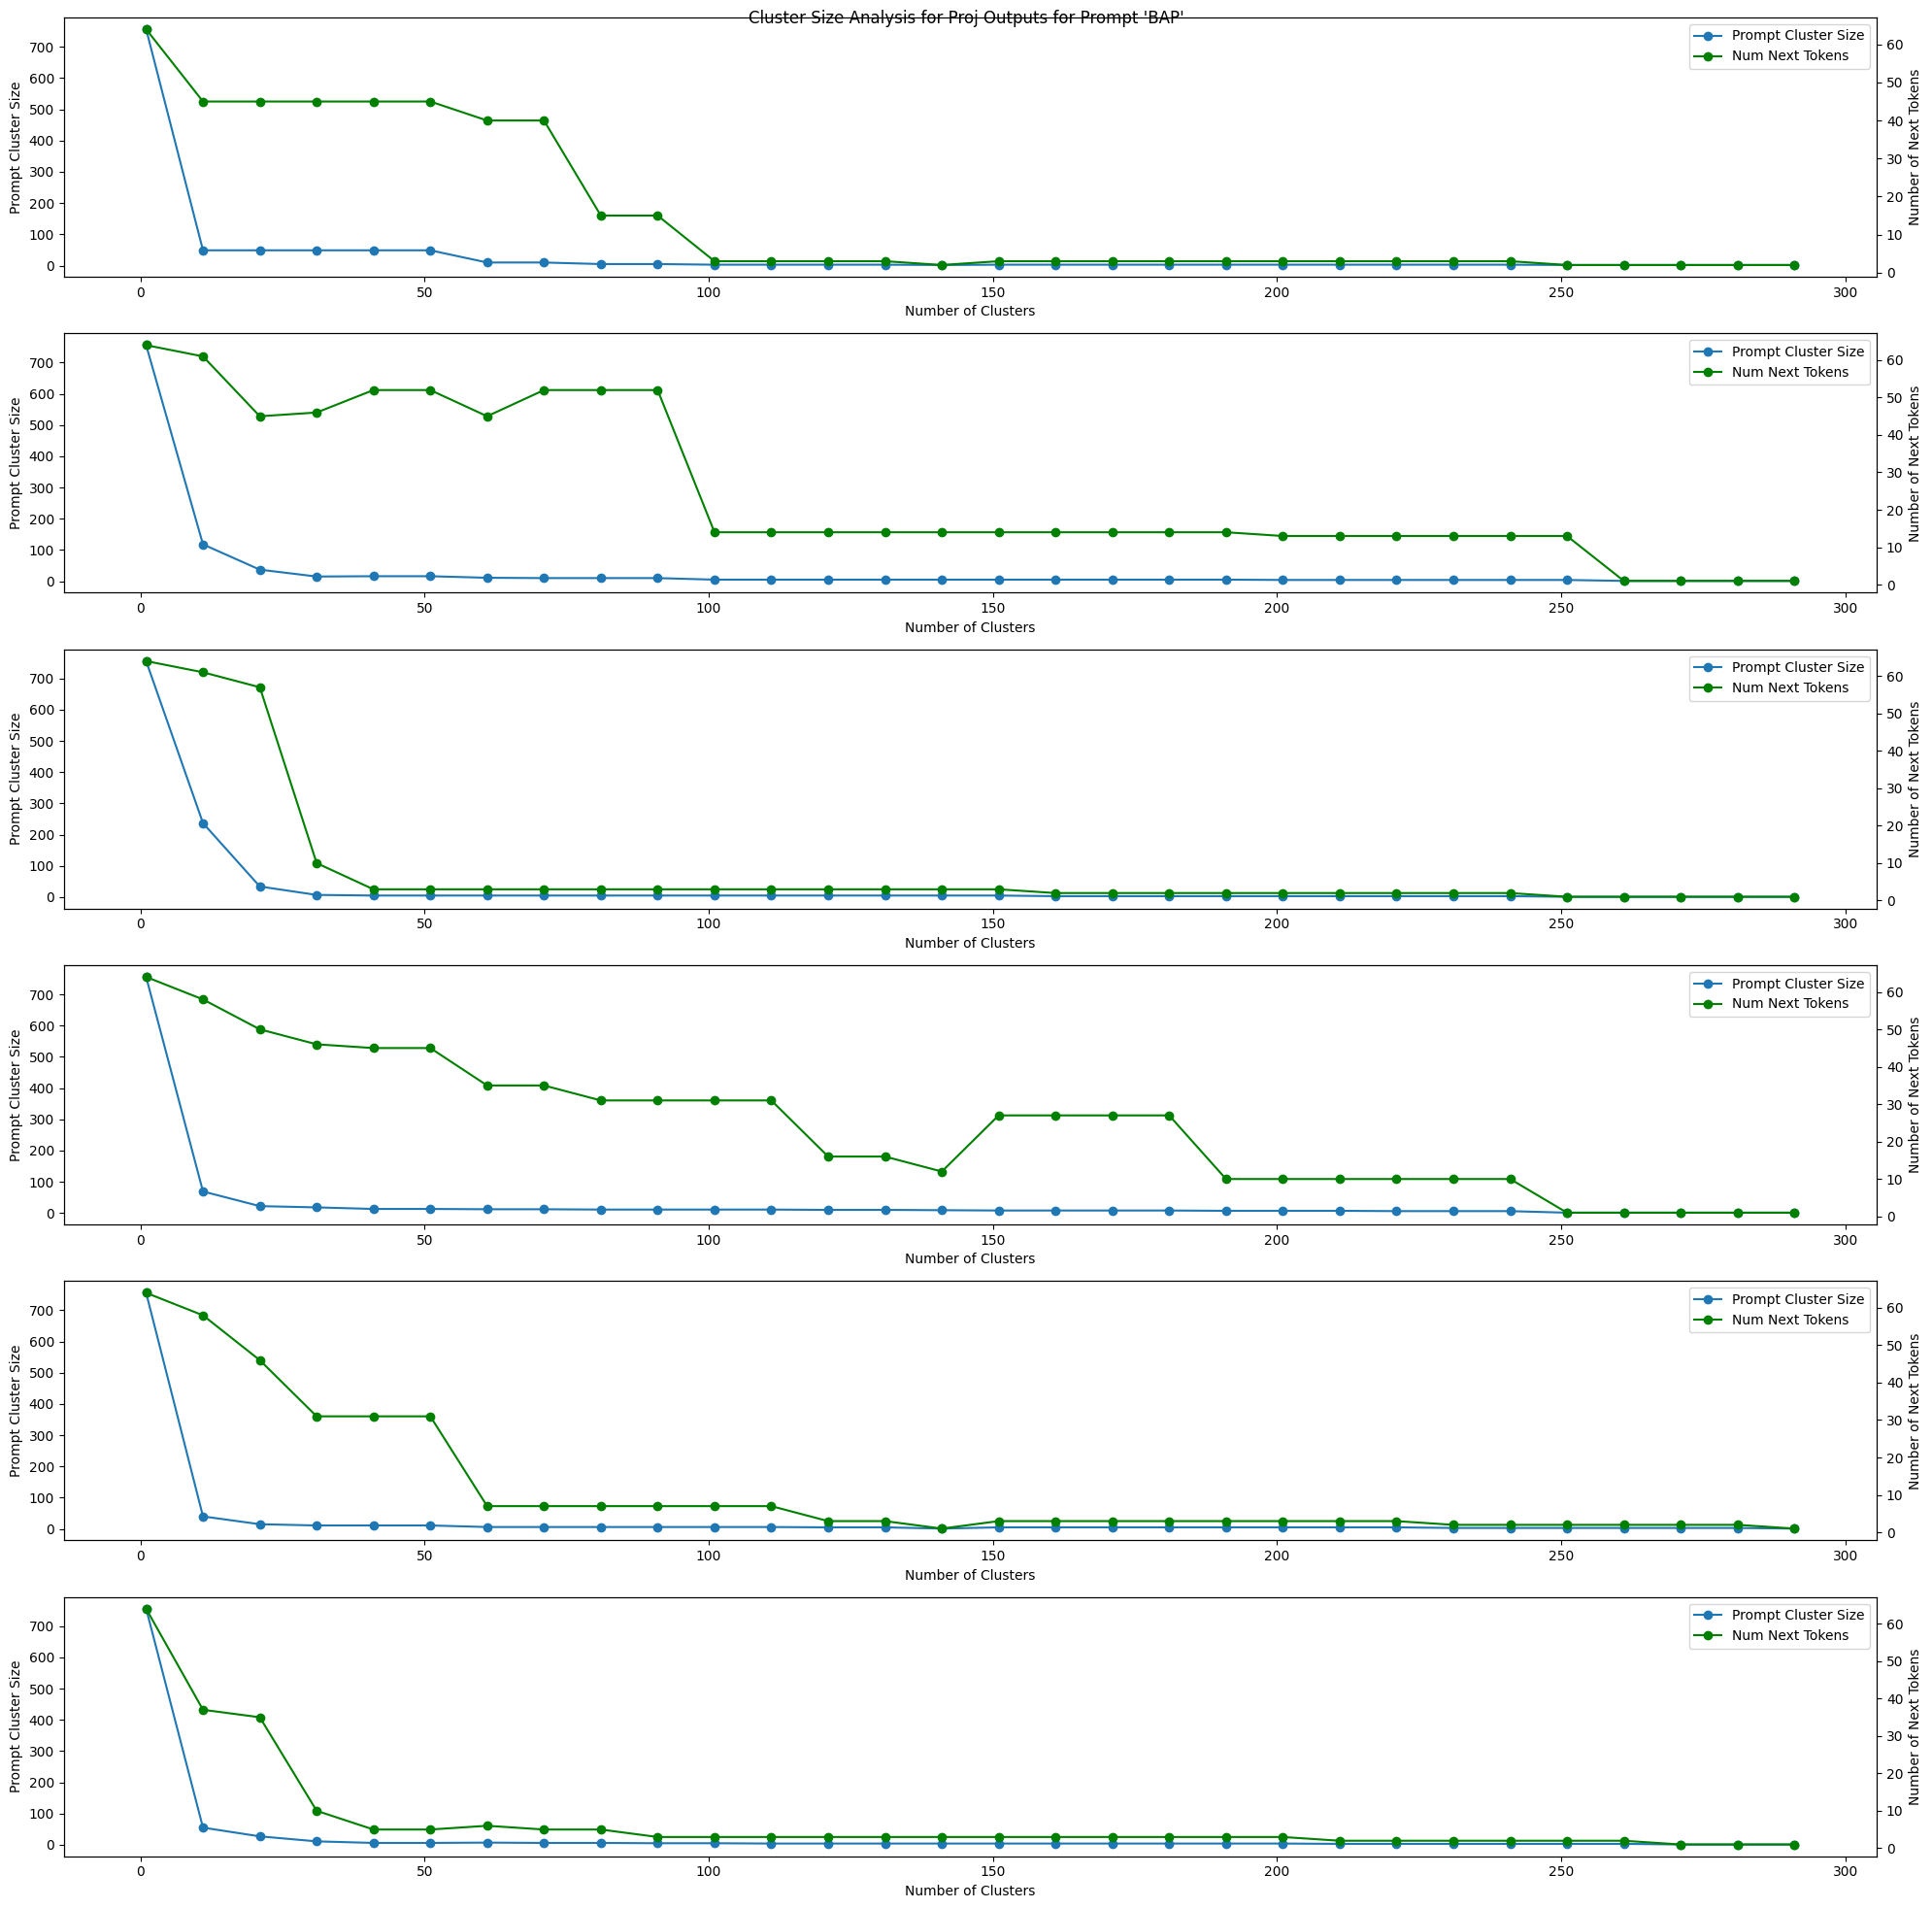

In [ ]:
# | eval: false
# Do the cluster size analysis for the proj outputs across all blocks.
prompt = 'BAP'

proj_csas = []
for block_idx in range(n_layer):
    # Get all the substrs and proj outputs for strings of the same length as the prompt.
    substrs, proj_outputs = zip(
        *[
            (result.substring, result.proj_output)
            for result in block_internals_results[block_idx].values()
            if len(result.substring) == len(prompt)
        ]
    )
    proj_csas.append(
        ClusterSizeAnalysis(
            accessors,
            encoding_helpers,
            prompt,
            range(1, 300, 10),
            substrs,
            torch.stack(proj_outputs),
            ts.text,
        )
    )

fig, axes = plt.subplots(nrows=n_layer, ncols=1, figsize=(20, 20))
fig.suptitle(f"Cluster Size Analysis for Proj Outputs for Prompt {repr(prompt)}")
for block_idx, csa in enumerate(proj_csas):
    csa.plot(ax=axes[block_idx], title=f'Block {block_idx}')
fig.tight_layout()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

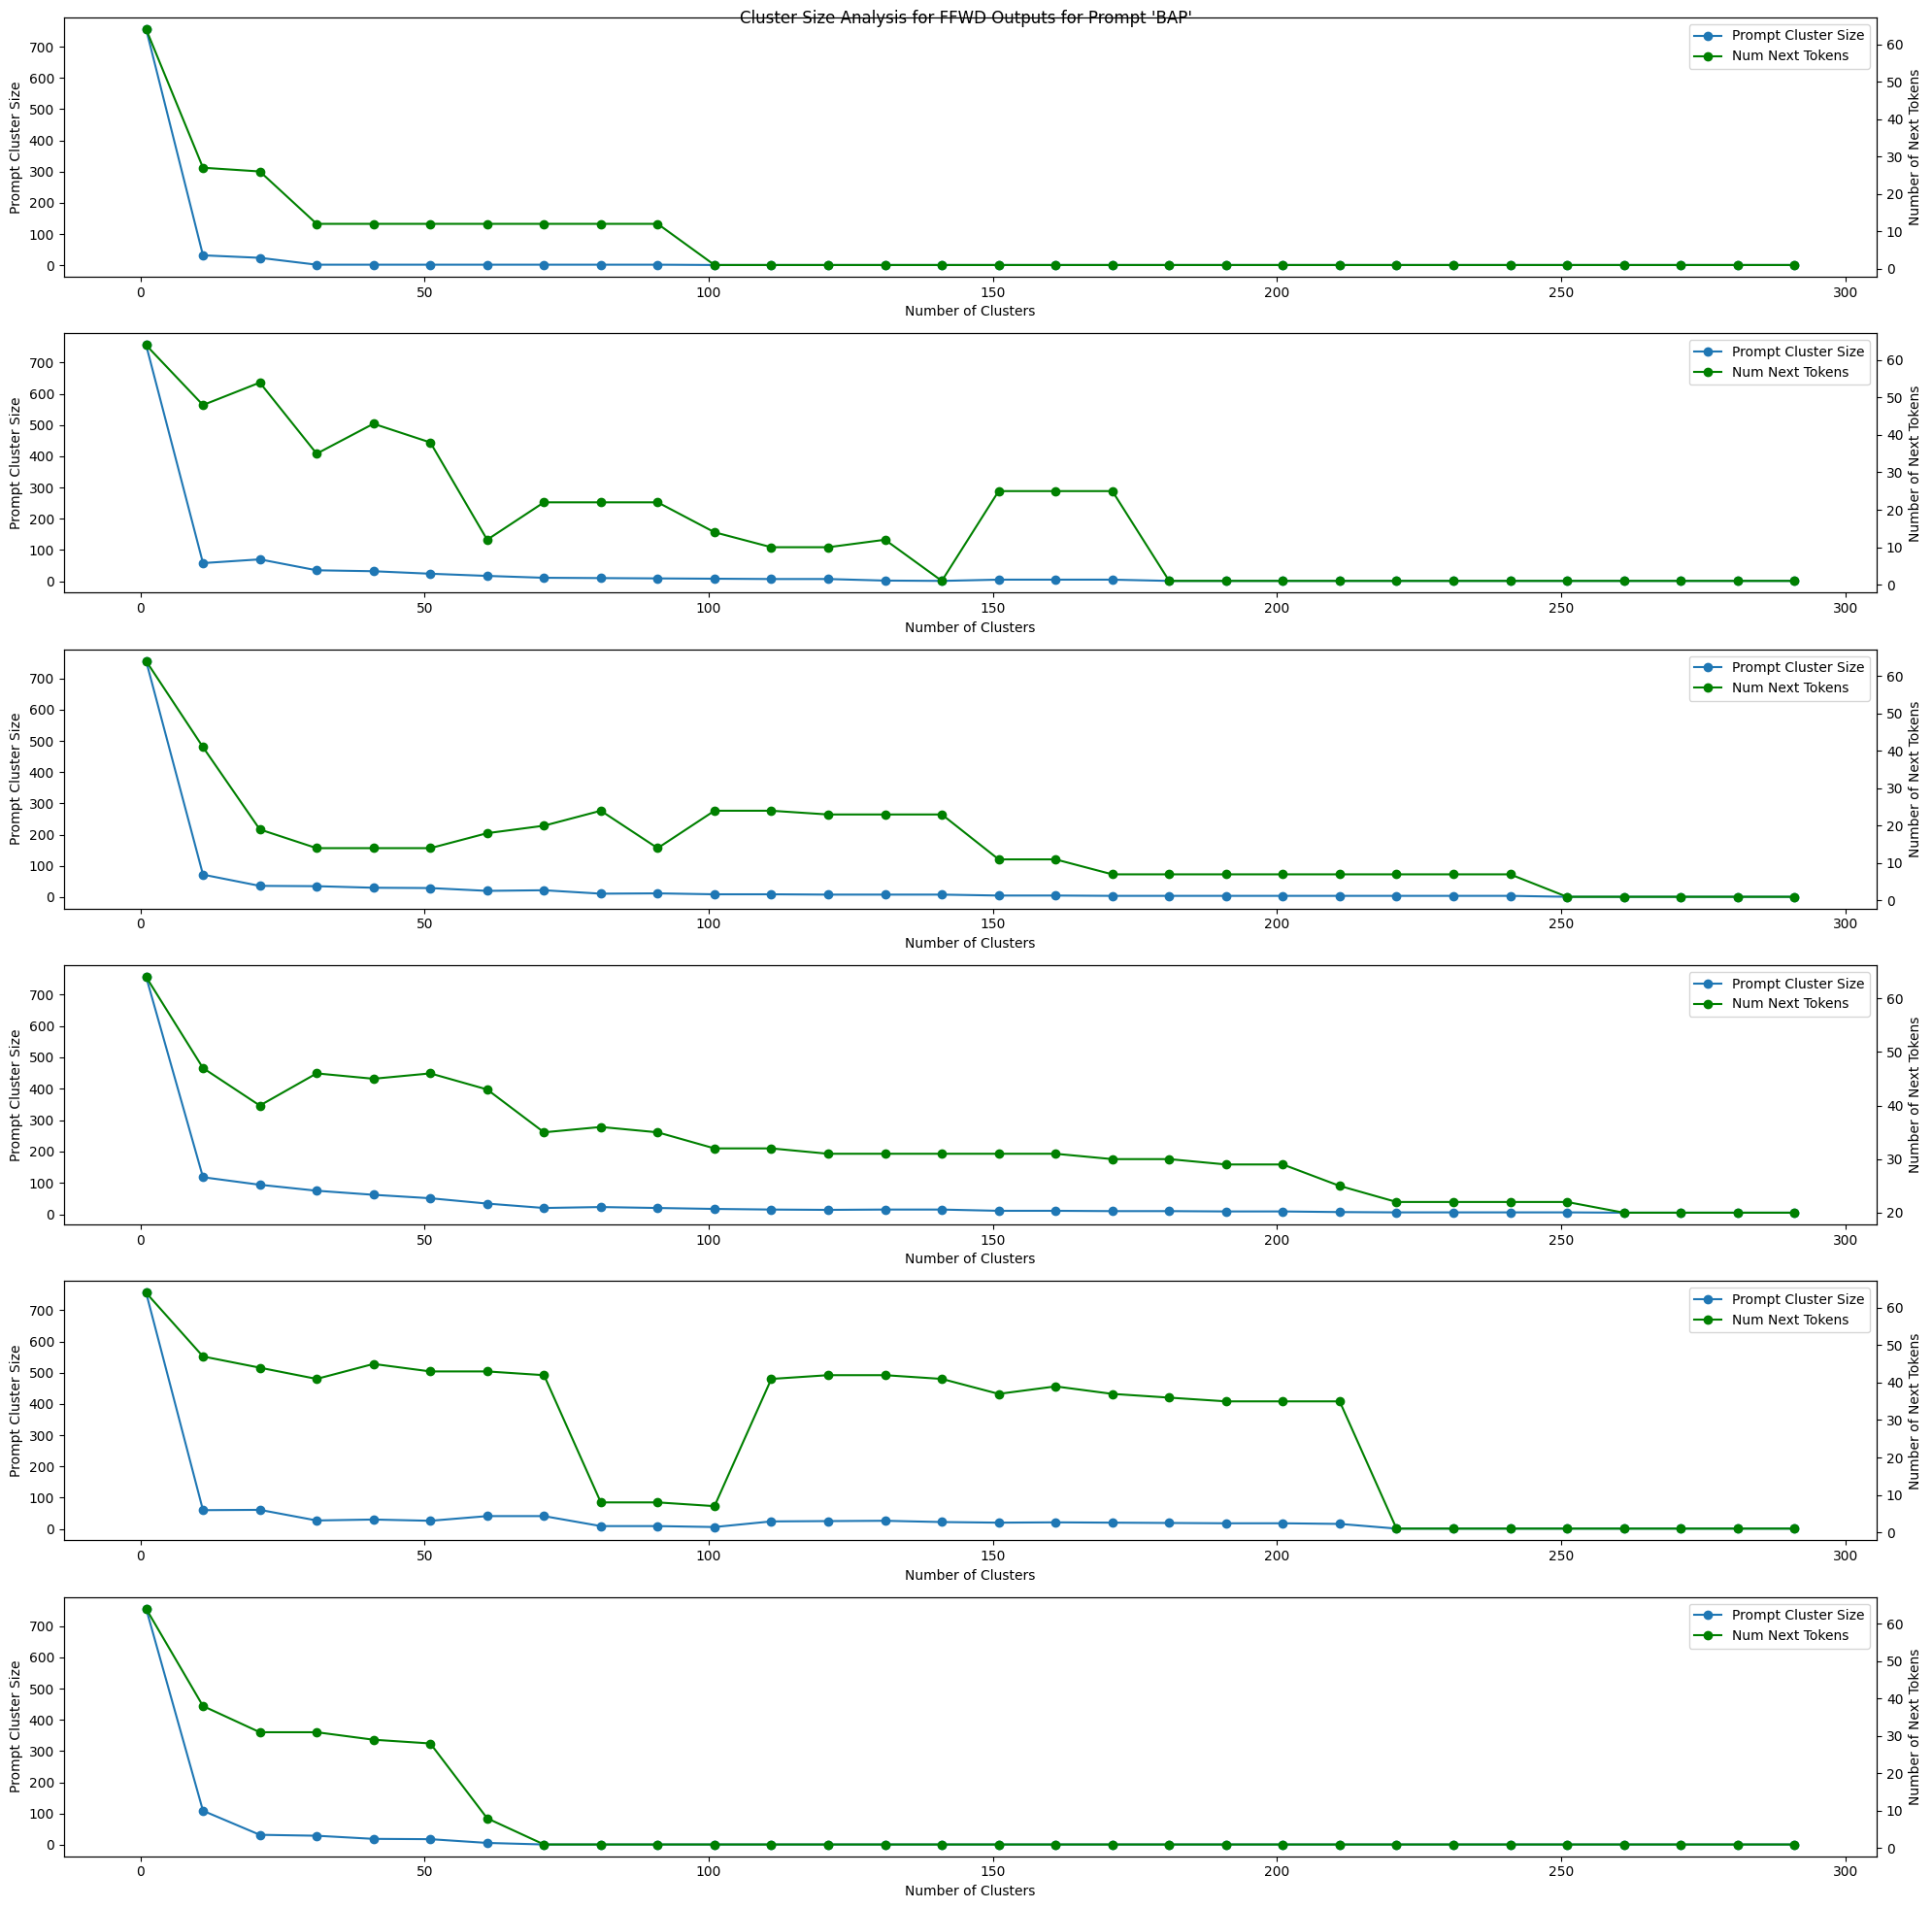

In [ ]:
# | eval: false
# Do the cluster size analysis for the ffwd outputs across all blocks.
prompt = 'BAP'

ffwd_csas = []
for block_idx in range(n_layer):
    # Get all the substrs and proj outputs for strings of the same length as the prompt.
    substrs, ffwd_outputs = zip(
        *[
            (result.substring, result.ffwd_output)
            for result in block_internals_results[block_idx].values()
            if len(result.substring) == len(prompt)
        ]
    )
    ffwd_csas.append(
        ClusterSizeAnalysis(
            accessors,
            encoding_helpers,
            prompt,
            range(1, 300, 10),
            substrs,
            torch.stack(ffwd_outputs),
            ts.text,
        )
    )

fig, axes = plt.subplots(nrows=n_layer, ncols=1, figsize=(20, 20))
fig.suptitle(f"Cluster Size Analysis for FFWD Outputs for Prompt {repr(prompt)}")
for block_idx, csa in enumerate(ffwd_csas):
    csa.plot(ax=axes[block_idx], title=f'Block {block_idx}')
fig.tight_layout()

## Frequency analysis
Let's see what we can learn about how these clusters relate to the input text. 

In [ ]:
# do it for the proj outputs
s = 'BAP'
for block_idx in range(n_layer):
    title = f'Block {block_idx} Proj Outputs'
    print(title)
    print(''.join(['-' for _ in range(len(title))]))
    print()
    clusters, substr_to_cluster = all_kmeans_results_proj_out[block_idx]
    cluster = substr_to_cluster[s]
    analysis = SubstringFrequencyAnalysis(cluster.substrs, ts.text, tokenizer.vocab_size, tokenizer.itos, tokenizer.stoi)
    analysis.print_summary()
    print()

Block 0 Proj Outputs
--------------------

Substrings: 'hat', ' a ', '\nAs', ' as', 'ian', 'BAP', 'har', 'fat', 'Was', 'tak', 'ear', 'pav', 'dam', 'mad', 'NA:', 'cal', 'NAT', 'Kat', 'ray', ' af', "ta'", 'eat', 'lav', 'way', 'pal', 'mak', 'rav', 'eak', 'hal', 'ran', 'par', ' an', '\nAn', 'mas', 'say', 'dau', ' ar', 'nap', 'tam', 'cab', 'hav', '-al', 'ead', 'rat', 'may', 'han', 'lab', 'eas', 'lan'
Top Tokens for each substring:
   'hat':  ' ' (3326),  'h' ( 378),  ',' ( 228),  "'" ( 173),  'e' (  99), '\n' (  68),  '?' (  43),  '!' (  21),  '.' (  14),  ';' (  13),  ':' (  12),  'r' (  12),  's' (   8),  'c' (   7),  't' (   3),  'i' (   2)
   ' a ':  's' ( 273),  'm' ( 238),  'p' ( 203),  'w' ( 193),  'b' ( 188),  't' ( 187),  'f' ( 172),  'c' ( 166),  'd' ( 148),  'g' ( 143),  'l' ( 139),  'h' ( 118),  'k' (  73),  'v' (  68),  'r' (  54),  'n' (  50),  'j' (  21),  'q' (  17),  'C' (  14),  'R' (  11),  'y' (  10),  'o' (   6),  'J' (   6),  'M' (   5),  'V' (   3),  'u' (   3),  'F' 

In [ ]:
# do it for the ffwd outputs

s = 'BAP'
for block_idx in range(n_layer):
    title = f'Block {block_idx} FFWD Outputs'
    print(title)
    print(''.join(['-' for _ in range(len(title))]))
    print()
    clusters, substr_to_cluster = all_kmeans_results_ffwd_out[block_idx]
    cluster = substr_to_cluster[s]
    analysis = SubstringFrequencyAnalysis(cluster.substrs, ts.text, tokenizer.vocab_size, tokenizer.itos, tokenizer.stoi)
    analysis.print_summary()
    print()


Block 0 FFWD Outputs
--------------------

Substrings: 'BAP', '\n\nP'
Top Tokens for each substring:
   'BAP':  'T' (  68)
 '\n\nP':  'E' ( 198),  'O' ( 117),  'R' ( 113),  'A' (  86),  'r' (  66),  'e' (  20),  'a' (  11),  'o' (   9),  'u' (   3),  'l' (   1),  'H' (   1)
Cumulative Top Tokens:
 'E' (0.29),  'O' (0.17),  'R' (0.16),  'A' (0.12),  'T' (0.10),  'r' (0.10),  'e' (0.03),  'a' (0.02),  'o' (0.01),  'u' (0.00),  'H' (0.00),  'l' (0.00)

Block 1 FFWD Outputs
--------------------

Substrings: 'ATH', 'RIN', 'TRU', 'UCH', 'BAP', 'IST', 'REM', 'NAT', 'IEL', 'PET', 'ENT', 'CEN', 'TON', 'ERO', 'ROS', 'ALO', 'SEB', 'ANT', 'LON'
Top Tokens for each substring:
   'ATH':  'A' (  85)
   'RIN':  'A' (  82),  'C' (  50)
   'TRU':  'C' ( 158)
   'UCH':  'I' ( 158),  'E' (  75)
   'BAP':  'T' (  68)
   'IST':  'A' (  68),  'R' (  15),  'O' (   2)
   'REM':  'I' (  58)
   'NAT':  'H' (   4)
   'IEL':  ':' (  25)
   'PET':  'R' ( 158),  'E' (  22)
   'ENT':  'I' ( 277),  'L' (   1)
   'CEN'

## Logit Lens View

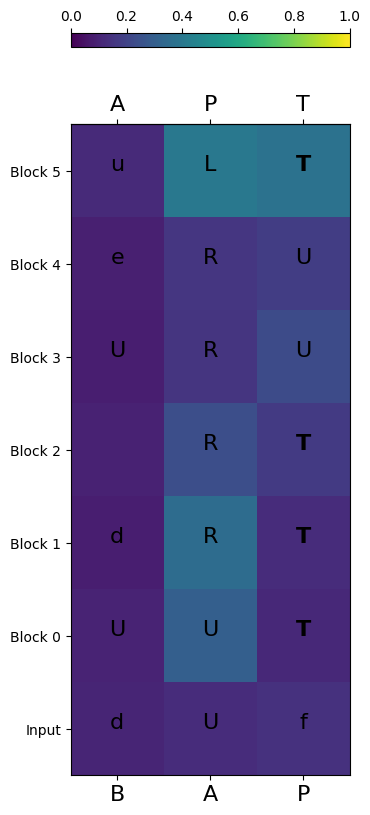

In [ ]:
logit_lens = LogitLens(encoding_helpers, accessors, 'BAP', 'APT')
logit_lens.plot()

In [ ]:
# Print the probabilities for the next token given a prompt
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'T' 0.376
'U' 0.296
'H' 0.066
':' 0.060
'E' 0.030
'R' 0.029
' ' 0.019
't' 0.017
'N' 0.017
'C' 0.012


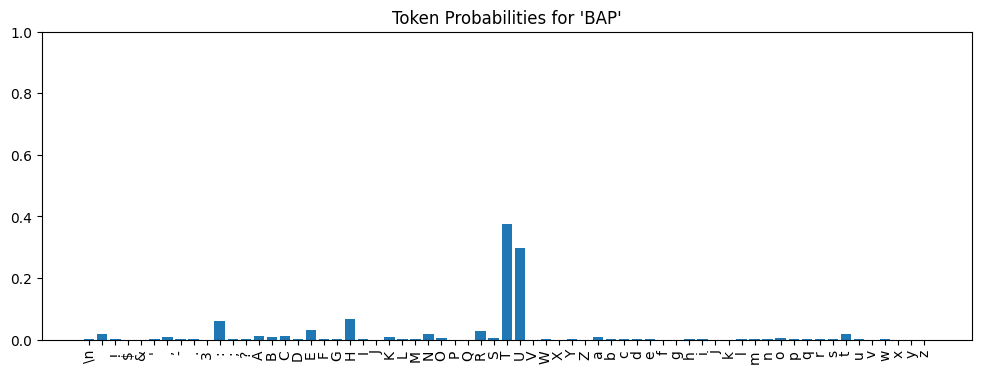

In [ ]:
# Plot them
logits.plot_probs(title=f'Token Probabilities for {repr(prompt)}')

In [ ]:
# See how it plays out in practice. 
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))


'BAPHAM:\n'
'BAPTIS:\n'
'BAPTIS:\n'
'BAPTIS:\n'
'BAPULET:'
'BAPTISTA'
'BAPULET:'
'BAPULET:'
'BAPULET:'
'BAPRINCE'


## Understanding adjustments made by the proj output and the ffwd output

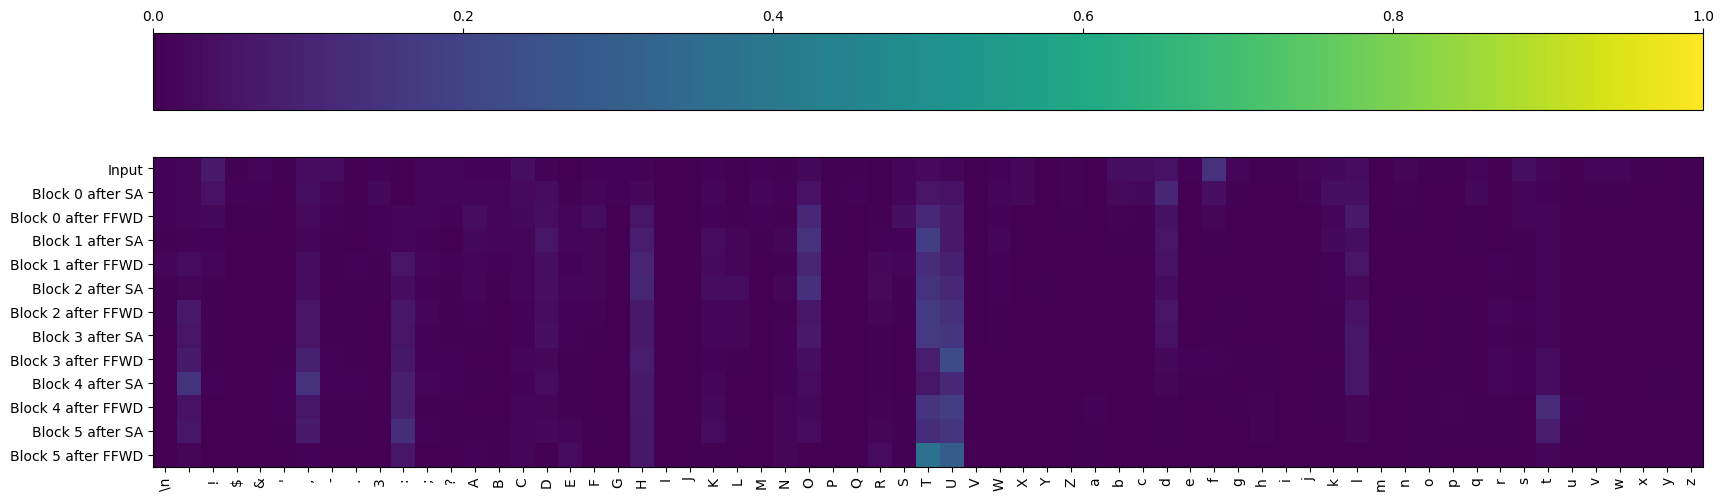

In [ ]:
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt='BAP')
bia.plot()